In [1]:
# import libraries

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Load pretrained VGG19

In [2]:
# Get features from VGG19
vgg = models.vgg19(pretrained=True).features

# Freeze weights
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# Make use of GPU only if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Load images

In [4]:
def load_image(img_path, max_size=400, shape=None):

    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    # image is normalized, resized and converted to tensor
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [5]:
# Load in content and style image
content = load_image('images/space_needle.jpg').to(device)

# Resize style to match content, makes code easier
style = load_image('images/delaunay.jpg', shape=content.shape[-2:]).to(device)

In [6]:
# Revert tensored image to CPU and display

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

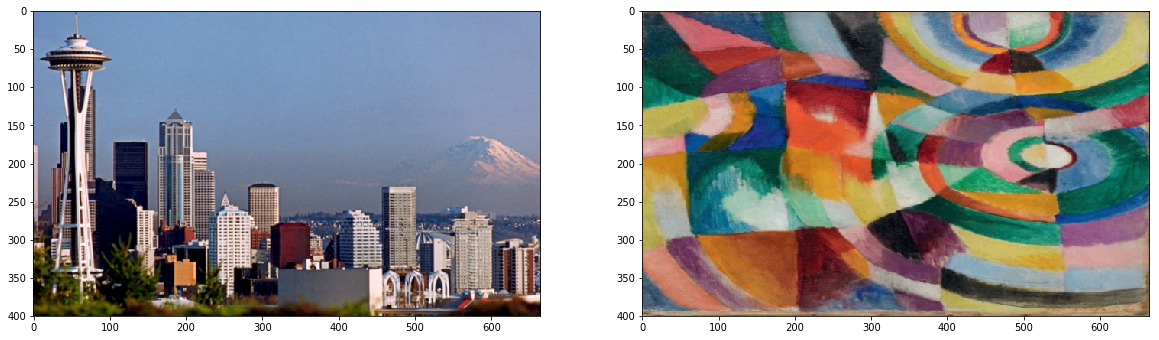

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [8]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

In [9]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Mapping layer names of PyTorch's VGGNet to names from the paper
    ## Layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}
    
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Calculating Gram matrix

In [10]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
    """
    
    ## get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(d, h*w)
    ## calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    return gram 

In [11]:
# Get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

### Content and style weights

In [12]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Calculating losses

Total loss:  23857586.0


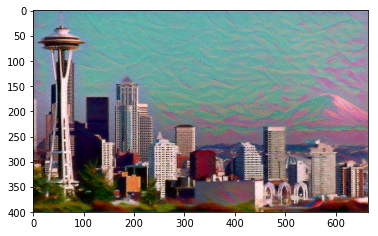

Total loss:  10137794.0


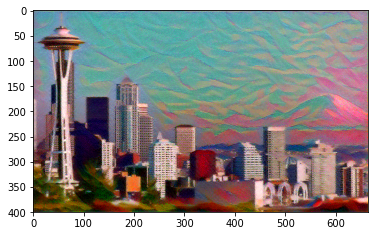

Total loss:  4811156.0


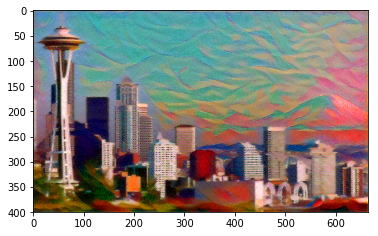

Total loss:  2577370.75


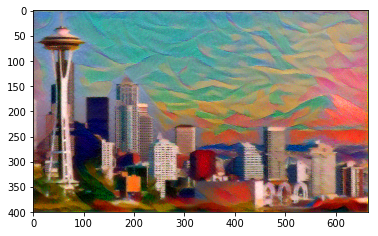

Total loss:  1514505.125


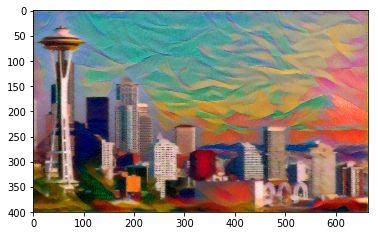

Total loss:  937857.75


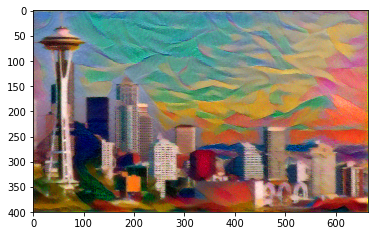

Total loss:  621860.1875


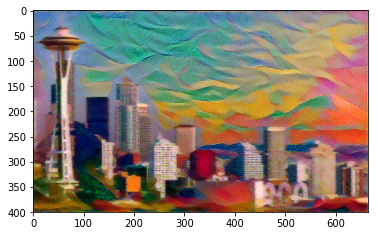

Total loss:  444942.96875


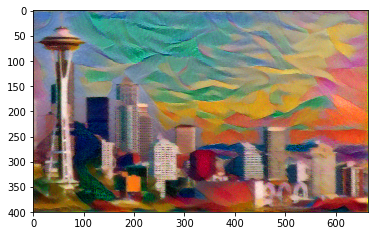

Total loss:  337031.8125


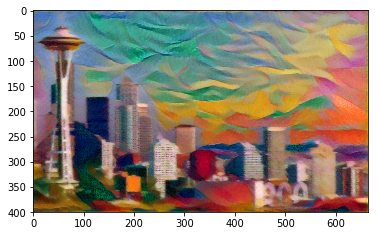

Total loss:  264087.15625


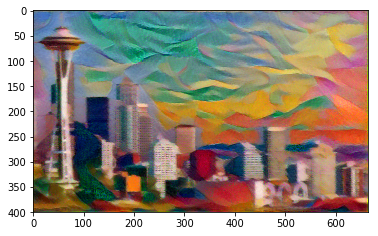

Total loss:  211036.296875


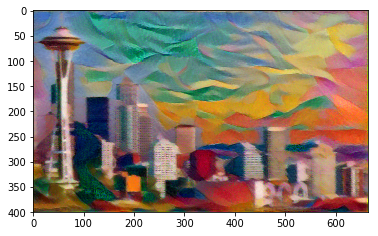

Total loss:  170910.5625


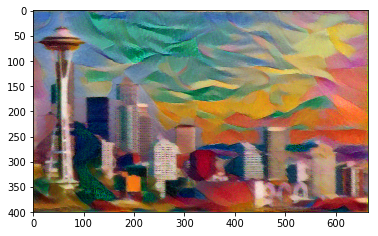

In [13]:
# Displaying the target image after 400 steps
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  

for ii in range(1, steps+1):
    
    # Get the features from your target image and then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # initialize the style loss to 0
    style_loss = 0
    
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        # get the "style" style representation
        style_gram = style_grams[layer]
        
        # calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    # calculate the *total* loss
    total_loss = content_weight*content_loss + style_weight*style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Visualize test results

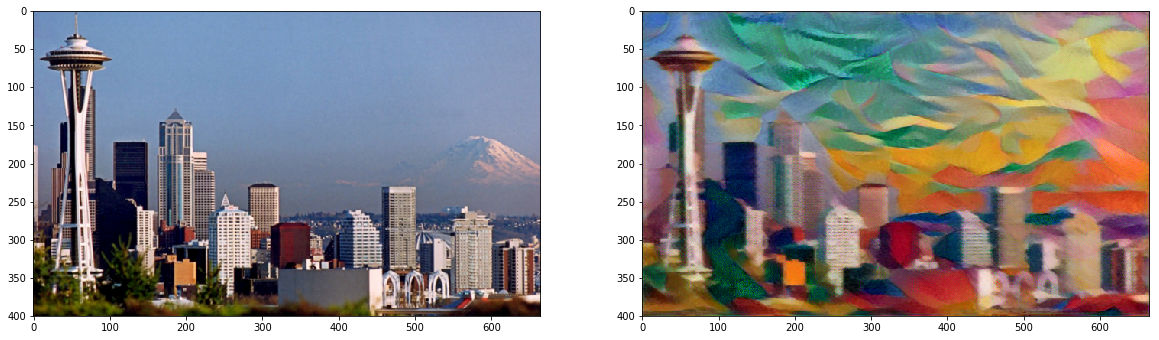

In [15]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))